In [1]:
!pip install spacy
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 115.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
!pip install transformers pandas tqdm

In [3]:
import spacy
import pandas as pd
import random

with open("20k_sentences_with_negation.txt", "r") as f:
    sentences = [line.strip() for line in f if line.strip()]

nlp = spacy.load("en_core_web_sm")

nouns, verbs, adjectives = set(), set(), set()

for sent in sentences:
    doc = nlp(sent)
    for token in doc:
        if token.pos_ == "NOUN":
            nouns.add(token.lemma_)
        elif token.pos_ == "VERB":
            verbs.add(token.lemma_)

print(f"Extracted {len(nouns)} nouns, {len(verbs)} verbs")

Extracted 100 nouns, 99 verbs


In [4]:
nouns = sorted([n for n in nouns if n.isalpha() and len(n) > 2])
verbs = sorted([v for v in verbs if v.isalpha() and len(v) > 2])
names = ["John", "Mary", "Alex", "David", "Sarah"]
# adjectives = sorted([a for a in adjectives if a.isalpha() and len(a) > 2])

templates = {
    "simple": "The {subj} didn’t {verb} any {obj}.",
    "rel_clause": "The {subj} that {name} saw didn’t {verb} any {obj}.",
    "adv_clause": "After the incident, the {subj} didn’t {verb} any {obj}.",
    "complex": "Although it was late, the {subj} didn’t {verb} any {obj}."
}

def generate_augmented(n):

    data = []
    for _ in range(n):

        subj = random.choice(nouns)
        obj = random.choice(nouns)
        if subj == obj:
            continue

        verb = random.choice(verbs)
        # adj = random.choice(adjectives)
        name = random.choice(names)

        for key, temp in templates.items():
            sentence = temp.format(subj = subj, verb = verb, obj = obj, name = name) # adj = adj
            data.append({"template": key, "sentence": sentence})

    return pd.DataFrame(data)

df_augmented = generate_augmented(1000)
df_augmented.to_csv("augmented_any_sentences.csv", index=False)

In [5]:
df_augmented

,template,sentence
0,simple,The mother didn’t change any version.
1,rel_clause,The mother that Alex saw didn’t change any ver...
2,adv_clause,"After the incident, the mother didn’t change a..."
3,complex,"Although it was late, the mother didn’t change..."
4,simple,The story didn’t prevent any war.
...,...,...
3939,complex,"Although it was late, the site didn’t ask any ..."
3940,simple,The development didn’t join any wife.
3941,rel_clause,The development that Sarah saw didn’t join any...
3942,adv_clause,"After the incident, the development didn’t joi..."


In [6]:
df_augmented = df_augmented.drop_duplicates(subset="sentence").copy()
print("Unique sentences:", len(df_augmented))

Unique sentences: 3937


In [7]:
import openai
import pandas as pd
from tqdm import tqdm

openai.api_key = "SECRET_KEY"

def gpt4o_logprob_score(sentence):
    try:
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "user", "content": f"Please return the total log probability of the following sentence:\n\n\"{sentence}\""},
            ],
            temperature=0,
            max_tokens=1,
            logprobs=True,  # logprob 기반 scoring
        )
        # token 단위 scoring을 유사하게 측정하거나 proxy로 사용할 수 있음
        return response.choices[0].logprobs

    except Exception as e:
        print(f"Error on sentence: {sentence}")
        return None

df_augmented["gpt4o_score"] = [gpt4o_logprob_score(s) for s in tqdm(df_augmented["sentence"])]

 77%|███████▋  | 3049/3937 [31:35<08:48,  1.68it/s]

KeyboardInterrupt: 

In [ ]:
df_augmented.to_csv("df_augmented.csv", index=False)

In [ ]:
df_inter = pd.read_csv("./df_augmented.csv")
df_inter["gpt4o_score"].head(10)

In [ ]:
import re

def extract_logprob_from_string(s):
    try:
        match = re.search(r"logprob=(-?\d+\.\d+)", s)
        if match:
            return float(match.group(1))
        else:
            return None
    except:
        return None

df_inter["score_numeric"] = df_inter["gpt4o_score"].apply(extract_logprob_from_string)

df_valid = df_inter.dropna(subset=["score_numeric"])
df_valid["score_numeric"] = pd.to_numeric(df_valid["score_numeric"])

k = 500
df_topk = df_valid.groupby("template", group_keys=False).apply(lambda x: x.nlargest(k, "score_numeric"))

df_topk.head()

In [ ]:
df_topk.to_csv("filtered_natural_sentences.csv", index=False)

In [4]:
df_topk = pd.read_csv("./filtered_natural_sentences.csv")

In [5]:
import torch
from transformers import BertTokenizer, BertForMaskedLM, GPT2Tokenizer, GPT2LMHeadModel

# BERT
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForMaskedLM.from_pretrained("bert-base-uncased")
bert_model.eval()

# GPT-2
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [6]:
def bert_score(sentence):

    masked = sentence.replace(" any ", " [MASK] ")
    inputs = bert_tokenizer(masked, return_tensors="pt")

    mask_index = torch.where(inputs.input_ids == bert_tokenizer.mask_token_id)[1]

    with torch.no_grad():
        outputs = bert_model(**inputs)
    logits = outputs.logits[0, mask_index, :]

    prob = torch.softmax(logits, dim = -1)[0, bert_tokenizer.convert_tokens_to_ids("any")].item()

    return prob

def gpt2_perplexity_diff(sentence):

    ids_with = gpt2_tokenizer(sentence, return_tensors="pt").input_ids

    with torch.no_grad():
        loss_with = gpt2_model(ids_with, labels=ids_with).loss.item()

    sentence_wo_any = sentence.replace(" any", "")
    ids_without = gpt2_tokenizer(sentence_wo_any, return_tensors="pt").input_ids

    with torch.no_grad():
        loss_without = gpt2_model(ids_without, labels=ids_without).loss.item()

    return loss_with - loss_without

In [7]:
from tqdm import tqdm

bert_probs = []
gpt2_diffs = []

for s in tqdm(df_topk["sentence"], desc="score_numeric"):
    bert_probs.append(bert_score(s))
    gpt2_diffs.append(gpt2_perplexity_diff(s))

df_topk["bert_prob_any"] = bert_probs
df_topk["gpt2_perplexity_diff"] = gpt2_diffs
df_topk.to_csv("npi_syntax_results.csv", index=False)

score_numeric: 100%|██████████| 2000/2000 [04:11<00:00,  7.97it/s]


In [8]:
df_final = pd.read_csv("./npi_syntax_results.csv")

In [20]:
df_final[df_final["template"] == "simple"]['bert_prob_any'].mean()

np.float64(0.03262654511344222)

<ipython-input-21-1de1226b5752>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final, x="template", y="bert_prob_any", palette="Greens")


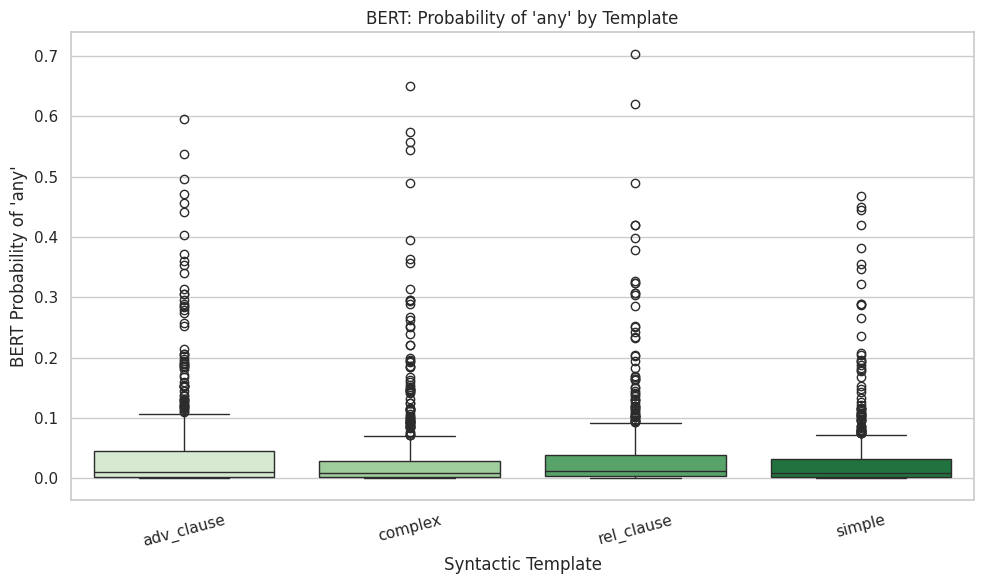

<ipython-input-21-1de1226b5752>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final, x="template", y="gpt2_perplexity_diff", palette="Greens")


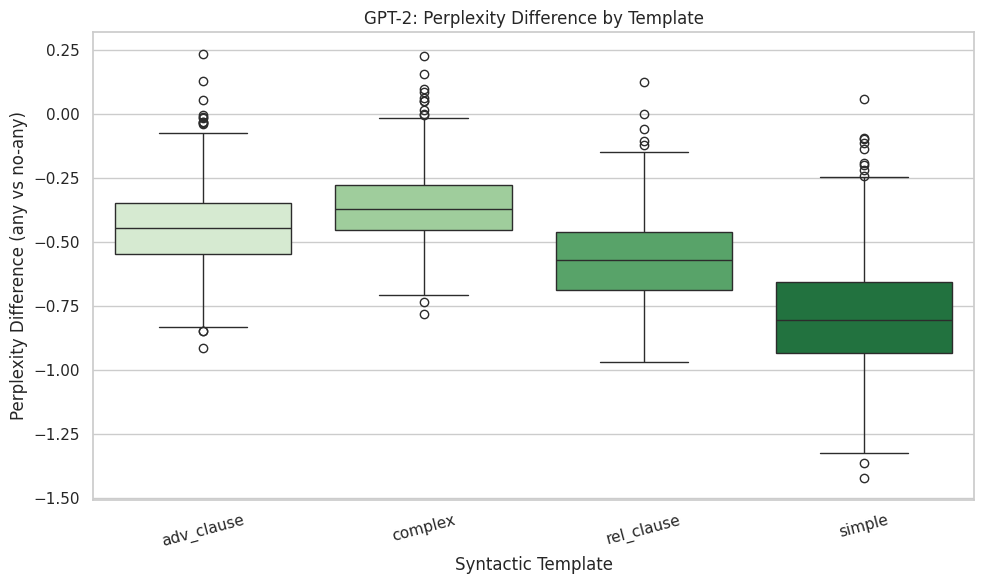

<ipython-input-21-1de1226b5752>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final, x="template", y="score_numeric", palette="Greens")


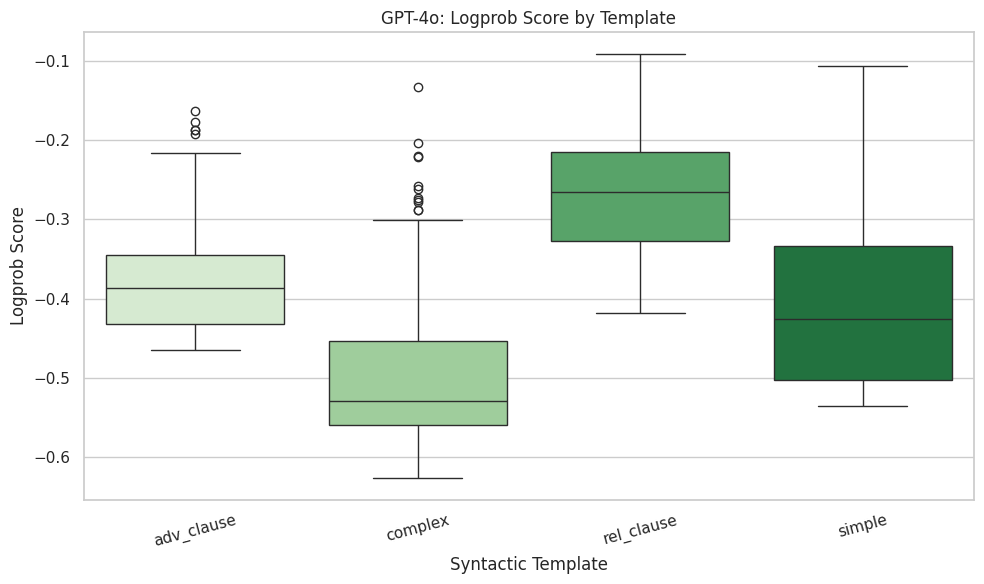

,template,bert_prob_any_mean,bert_prob_any_std,bert_prob_any_count,gpt2_perplexity_diff_mean,gpt2_perplexity_diff_std,gpt2_perplexity_diff_count,score_numeric_mean,score_numeric_std,score_numeric_count
0,adv_clause,0.044158,0.083599,500,-0.441570,0.164699,500,-0.378757,0.063019,500
1,complex,0.037868,0.080136,500,-0.363993,0.147458,500,-0.504267,0.085095,500
2,rel_clause,0.040384,0.077721,500,-0.566136,0.167156,500,-0.266912,0.070793,500
3,simple,0.032627,0.064949,500,-0.793507,0.219238,500,-0.402032,0.108030,500


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

sns.set(style="whitegrid")

# 1. BERT probability of 'any'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final, x="template", y="bert_prob_any", palette="Greens")
plt.title("BERT: Probability of 'any' by Template")
plt.ylabel("BERT Probability of 'any'")
plt.xlabel("Syntactic Template")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 2. GPT-2 perplexity difference
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final, x="template", y="gpt2_perplexity_diff", palette="Greens")
plt.title("GPT-2: Perplexity Difference by Template")
plt.ylabel("Perplexity Difference (any vs no-any)")
plt.xlabel("Syntactic Template")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 3. GPT-4o logprob score
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final, x="template", y="score_numeric", palette="Greens")
plt.title("GPT-4o: Logprob Score by Template")
plt.ylabel("Logprob Score")
plt.xlabel("Syntactic Template")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

summary_stats = df_final.groupby("template")[["bert_prob_any", "gpt2_perplexity_diff", "score_numeric"]].agg(["mean", "std", "count"])
summary_stats.columns = ["_".join(col) for col in summary_stats.columns]
summary_stats.reset_index(inplace=True)

summary_stats

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


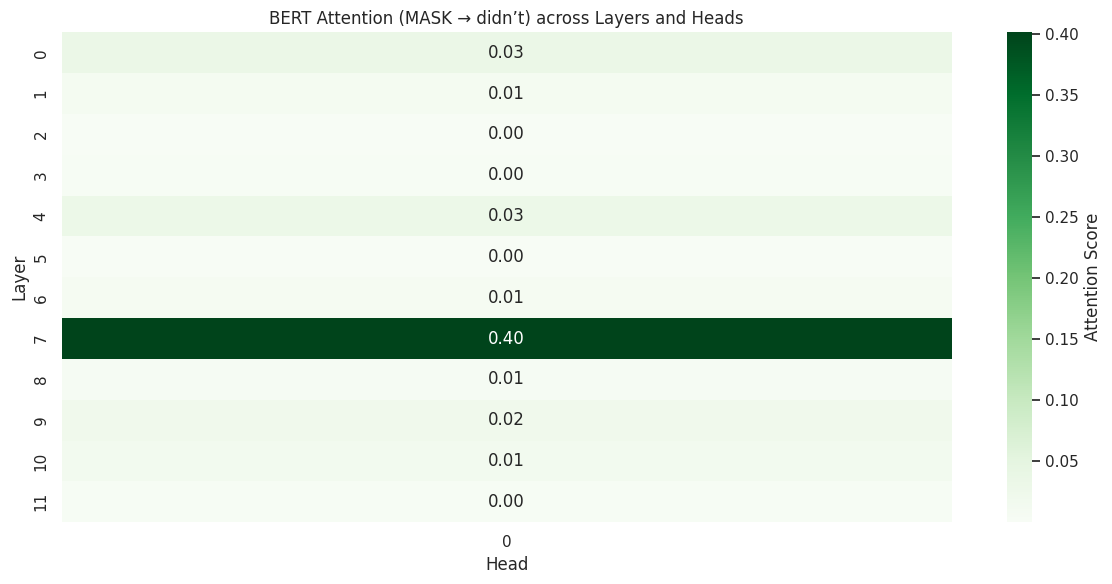

In [10]:
# BERT의 특정 layer/head가 any - didn't와 같은 NPI licensing 요소에 얼마나 집중하는지를 분석
# sentence → 마스킹된 상태 입력
# attention 행렬 추출: shape = [layers x heads x tokens x tokens]
# MASK 위치에서 licensing cue로 attention이 얼마나 분포되는지 측정

from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)
model.eval()

# sample sentence
sentence = "The man that John saw didn’t kill any people."
masked = sentence.replace(" any ", " [MASK] ")
inputs = tokenizer(masked, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

mask_idx = tokens.index("[MASK]")
didnt_idx = next(i for i, t in enumerate(tokens) if t.startswith("didn"))

with torch.no_grad():
    outputs = model(**inputs)
attentions = torch.stack(outputs.attentions)  # shape: [layers, heads, batch, from, to]

scores = attentions[:, :, 0, mask_idx, didnt_idx].numpy()  # [layer, head]

plt.figure(figsize=(12, 6))
sns.heatmap(scores, annot=True, fmt=".2f", cmap = "Greens", cbar_kws={'label': 'Attention Score'})
plt.title("BERT Attention (MASK → didn’t) across Layers and Heads")
plt.xlabel("Head")
plt.ylabel("Layer")
plt.tight_layout()
plt.show()

In [11]:
!pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.84.0
    Uninstalling openai-1.84.0:
      Successfully uninstalled openai-1.84.0


In [13]:
# Which of the following sentences is more natural?
# 1. A man didn't open any doors.
# 2. A man opened any doors.

# Respond with '1' or '2' only.

import openai
import pandas as pd
from tqdm import tqdm

openai.api_key = "SECRET_KEY"

def compare_with_gpt4o(sent1, sent2):
    prompt = f"""Which of the following sentences is more natural?
1. {sent1}
2. {sent2}

Respond with '1' or '2' only."""

    response = openai.ChatCompletion.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )

    return response.choices[0].message["content"].strip()

# Example dataframe
df_pairs = pd.DataFrame({
    "sentence1": ["A man didn’t open any doors.", "A man didn’t see any books."],
    "sentence2": ["A man opened any doors.", "A man saw any books."]
})

df_pairs["gpt4o_preference"] = [
    compare_with_gpt4o(row.sentence1, row.sentence2) for _, row in tqdm(df_pairs.iterrows(), total=len(df_pairs))
]



100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


In [14]:
df_pairs

,sentence1,sentence2,gpt4o_preference
0,A man didn’t open any doors.,A man opened any doors.,1
1,A man didn’t see any books.,A man saw any books.,1
